<a href="https://colab.research.google.com/github/gitHubAndyLee2020/LLM_Reward_Model_Research/blob/main/Reward_Model_Module_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Data

In [1]:
from google.colab import files
uploaded = files.upload()

Saving df_train_first100_ranked.csv to df_train_first100_ranked.csv


In [2]:
import pandas as pd

# Load the CSV file into a DataFrame
df_train_first100_ranked = pd.read_csv('df_train_first100_ranked.csv')
# Replace NaN values with an empty string
df_train_first100_ranked = df_train_first100_ranked.fillna('')

In [3]:
df_train_first100_ranked.head()

,id,system_prompt,question,response,instruct_model_response,openorca_model_response,response_rank,instruct_model_response_rank,openorca_model_response_rank
0,niv.242684,,You will be given a definition of a task first...,"[\n [""AFC Ajax (amateurs)"", ""has ground"", ""Sp...","Sure, I can help you with that task. Can you p...",[SOL]\nThe output for the given sentence shoul...,1,3,2
1,flan.564327,You are an AI assistant. You will be given a t...,Generate an approximately fifteen-word sentenc...,Midsummer House is a moderately priced Chinese...,Midsummer House is a restaurant that serves Ch...,At the moderately-priced Midsummer House near ...,2,3,1
2,flan.1875913,"You are a helpful assistant, who always provid...",What happens next in this paragraph?\n\nShe th...,C. She then dips the needle in ink and using t...,It is not clear what happens next in the parag...,C. So after she finishes pouring the liquids i...,2,3,1
3,t0.408370,You are an AI assistant. You will be given a t...,Please answer the following question: I want t...,"Based on the passage, discuss the primary moti...","Sure, here's a question that could test the ab...","Based on the passage given, you might develop ...",1,2,3
4,cot.86217,You are an AI assistant that helps people find...,James runs a TV show and there are 5 main char...,"James pays the minor characters $15,000 each e...","James pays the minor characters $15,000 each e...",James pays the major characters three times as...,1,3,2


In [4]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.0 MB/s eta 0:00:00


In [5]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load the tokenizer and bert_model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [6]:
import numpy as np

def get_token_counts(df, columns):
    # Tokenize the values in the columns and get the count of tokens for each string
    token_counts = df[columns].applymap(
        lambda x: len(tokenizer.tokenize(str(x)))
    )

    # Convert the DataFrame to a numpy array and then flatten it
    token_counts_array = token_counts.values.flatten()

    return token_counts_array

In [7]:
system_prompt_token_counts = get_token_counts(df_train_first100_ranked, ['system_prompt'])
question_token_counts = get_token_counts(df_train_first100_ranked, ['question'])
response_all_token_counts = get_token_counts(df_train_first100_ranked, ['response', 'instruct_model_response', 'openorca_model_response'])

In [8]:
print("system prompt max length:", system_prompt_token_counts.max())
print("question max length:", question_token_counts.max())
print("response max length:", response_all_token_counts.max())

system prompt max length: 79
question max length: 1023
response max length: 753


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def graph_distribution(data, bin_size, title):
  bins = np.arange(data.min(), data.max() + bin_size + 1, bin_size)

  # Find the 95% percentile
  percentile_95 = np.percentile(data, 95)

  # Plotting the histogram
  plt.hist(data, bins=bins, edgecolor='black', align='left')
  plt.title(title)
  plt.xlabel('Value Range')
  plt.ylabel('Frequency')
  plt.xticks(bins)
  plt.grid(axis='y')

  # Draw a vertical red line at the 95% percentile
  plt.axvline(percentile_95, color='red', linestyle='dashed', linewidth=1)
  plt.text(percentile_95+1, plt.gca().get_ylim()[1]-5, '95th Percentile', color = 'red')

  # Display the histogram
  plt.show()

  print("95% Percentile at", percentile_95)

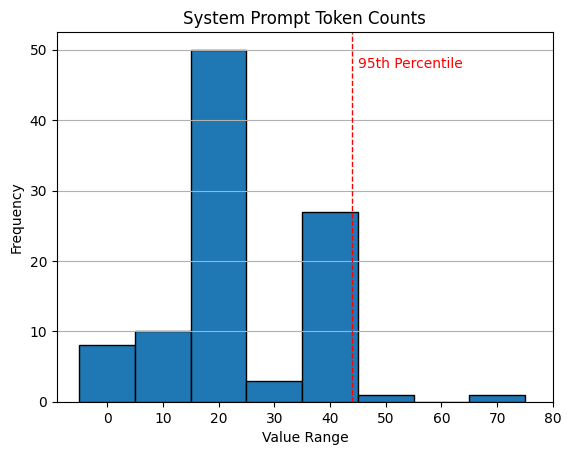

95% Percentile at 44.0


In [10]:
graph_distribution(system_prompt_token_counts, 10, "System Prompt Token Counts")

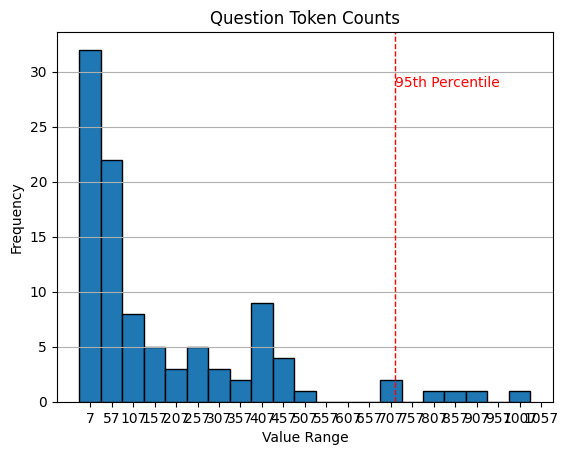

95% Percentile at 716.55


In [11]:
graph_distribution(question_token_counts, 50, "Question Token Counts")

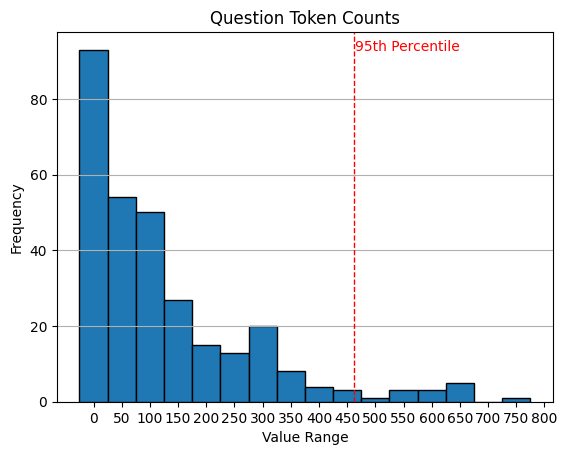

95% Percentile at 462.5500000000001


In [12]:
graph_distribution(response_all_token_counts, 50, "Question Token Counts")

In [13]:
def get_embeddings(sentences, max_length, batch_size=32):
    all_embeddings = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i+batch_size]

        # Tokenize the batch of sentences
        tokens = tokenizer(batch_sentences, return_tensors="tf", padding='max_length', truncation=True, max_length=max_length)

        # Get embeddings using the tokens directly
        outputs = bert_model(**tokens)
        embeddings = outputs.last_hidden_state

        # Pad the embeddings tensor to match the max_length
        padding_size = max_length - embeddings.shape[1]
        if padding_size > 0:
            padding = tf.zeros([embeddings.shape[0], padding_size, embeddings.shape[2]])
            embeddings = tf.concat([embeddings, padding], axis=1)

        all_embeddings.append(embeddings)

    return tf.concat(all_embeddings, axis=0)

In [14]:
system_prompt_embeddings = get_embeddings(list(df_train_first100_ranked['system_prompt']), 64)
question_embeddings = get_embeddings(list(df_train_first100_ranked['question']), 512)
response_embeddings = get_embeddings(list(df_train_first100_ranked['response']), 512)
instruct_model_response_embeddings = get_embeddings(list(df_train_first100_ranked['instruct_model_response']), 512)
openorca_model_response_embeddings = get_embeddings(list(df_train_first100_ranked['openorca_model_response']), 512)

In [15]:
system_prompt_embeddings.shape, question_embeddings.shape, response_embeddings.shape, instruct_model_response_embeddings.shape, openorca_model_response_embeddings.shape

(TensorShape([100, 64, 768]),
 TensorShape([100, 512, 768]),
 TensorShape([100, 512, 768]),
 TensorShape([100, 512, 768]),
 TensorShape([100, 512, 768]))

In [16]:
# Concatenate the embeddings along the sequence length dimension (axis=1)
concatenated_embeddings = tf.concat([system_prompt_embeddings,
                                     question_embeddings,
                                     response_embeddings,
                                     instruct_model_response_embeddings,
                                     openorca_model_response_embeddings], axis=1)

print(concatenated_embeddings.shape)

(100, 2112, 768)


In [17]:
X_train = concatenated_embeddings

In [18]:
import numpy as np

# Create a new column 'tuple_rank' that combines the rankings as a tuple
df_train_first100_ranked['tuple_rank'] = list(zip(df_train_first100_ranked['response_rank'],
                                                 df_train_first100_ranked['instruct_model_response_rank'],
                                                 df_train_first100_ranked['openorca_model_response_rank']))

# Create a mapping from ranking tuple to one-hot encoded label
rank_map = {
    (1, 2, 3): [1, 0, 0, 0, 0, 0],
    (1, 3, 2): [0, 1, 0, 0, 0, 0],
    (2, 1, 3): [0, 0, 1, 0, 0, 0],
    (2, 3, 1): [0, 0, 0, 1, 0, 0],
    (3, 1, 2): [0, 0, 0, 0, 1, 0],
    (3, 2, 1): [0, 0, 0, 0, 0, 1]
}

# Convert 'tuple_rank' to one-hot encoded labels and assign to y_train
y_train = np.array(df_train_first100_ranked['tuple_rank'].map(rank_map).tolist())

In [19]:
X_train.shape, y_train.shape

(TensorShape([100, 2112, 768]), (100, 6))

### One-Hot Encoding

- A, B, C -> (1, 2, 3) -> [1, 0, 0, 0, 0, 0]
- A, C, B -> (1, 3, 2) -> [0, 1, 0, 0, 0, 0]
- B, A, C -> (2, 1, 3) -> [0, 0, 1, 0, 0, 0]
- B, C, A -> (2, 3, 1) -> [0, 0, 0, 1, 0, 0]
- C, A, B -> (3, 1, 2) -> [0, 0, 0, 0, 1, 0]
- C, B, A -> (3, 2, 1) -> [0, 0, 0, 0, 0, 1]

### List Reward Model

In [20]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the model
model = tf.keras.Sequential([
    layers.Flatten(input_shape=(2112, 768)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')  # 6 units for all permutations of A, B, C
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1622016)           0         
                                                                 
 dense (Dense)               (None, 512)               830472704 
                                                                 
 dropout_37 (Dropout)        (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_38 (Dropout)        (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 830605574 (3.09 GB)
Trainable params: 8306

In [21]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
3/3 [==============================] - 4s 228ms/step - loss: 102.2699 - accuracy: 0.3000 - val_loss: 109.2691 - val_accuracy: 0.4500
Epoch 2/10
3/3 [==============================] - 0s 109ms/step - loss: 174.3673 - accuracy: 0.3500 - val_loss: 131.6196 - val_accuracy: 0.3000
Epoch 3/10
3/3 [==============================] - 0s 103ms/step - loss: 170.9216 - accuracy: 0.4625 - val_loss: 126.5059 - val_accuracy: 0.3000
Epoch 4/10
3/3 [==============================] - 0s 109ms/step - loss: 115.8394 - accuracy: 0.5500 - val_loss: 163.0789 - val_accuracy: 0.2500
Epoch 5/10
3/3 [==============================] - 0s 107ms/step - loss: 140.4651 - accuracy: 0.6125 - val_loss: 139.7240 - val_accuracy: 0.3000
Epoch 6/10
3/3 [==============================] - 0s 106ms/step - loss: 89.3332 - accuracy: 0.6750 - val_loss: 120.0826 - val_accuracy: 0.2500
Epoch 7/10
3/3 [==============================] - 0s 104ms/step - loss: 109.7680 - accuracy: 0.7125 - val_loss: 155.0399 - val_accuracy: 

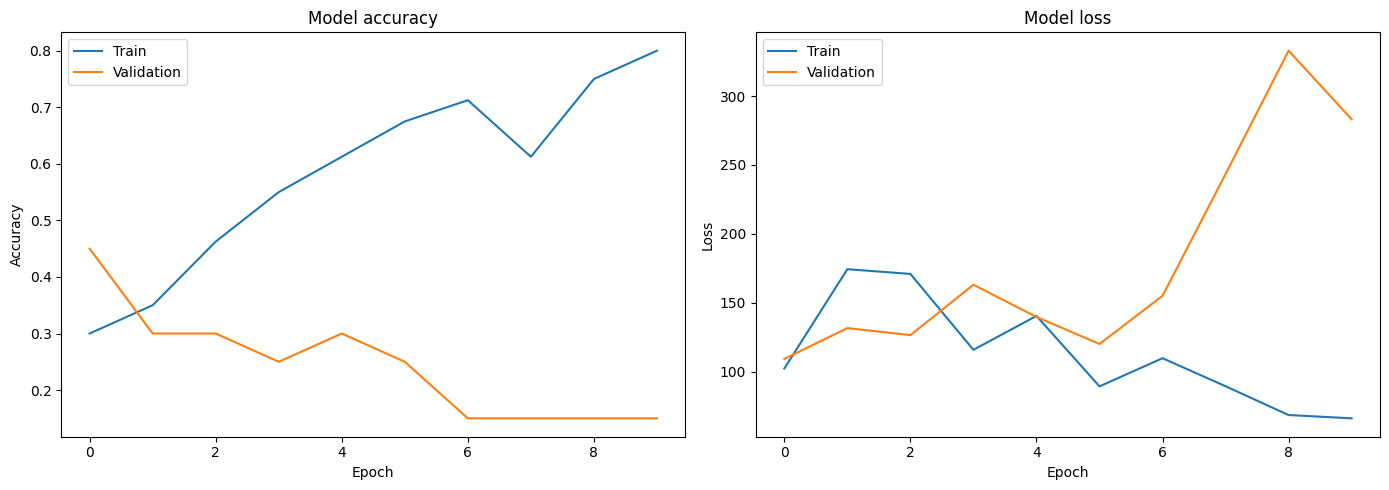

In [22]:
# Plotting training history (optional)
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

### Test Model

In [23]:
# 1. Generate Synthetic Test Strings
test_sentences_system_prompt = ["You are a helpful assistant designed to provide information on a variety of topics."]
test_sentences_question = ["What's the difference between classical and quantum computing?"]
test_sentences_response = ["Classical computing uses bits (0s or 1s), while quantum computing uses qubits, which can be both 0 and 1 simultaneously due to superposition. This gives quantum computers potential for greater computational power."]
test_sentences_instruct_model_response = ["Classical computers use bits, either 0 or 1. Quantum computers use qubits that can represent both 0 and 1 at the same time, allowing them to process more information."]
test_sentences_openorca_model_response = ["Regular computers use bits. Quantum ones use qubits that can be 0 and 1 at once. It's like they're super-charged!"]

# 2. Convert Strings to Embeddings
embeddings_system_prompt = get_embeddings(test_sentences_system_prompt, 64)
embeddings_question = get_embeddings(test_sentences_question, 512)
embeddings_response = get_embeddings(test_sentences_response, 512)
embeddings_instruct_model_response = get_embeddings(test_sentences_instruct_model_response, 512)
embeddings_openorca_model_response = get_embeddings(test_sentences_openorca_model_response, 512)

# 3. Concatenate Embeddings
X_test = tf.concat([
    embeddings_system_prompt,
    embeddings_question,
    embeddings_response,
    embeddings_instruct_model_response,
    embeddings_openorca_model_response], axis=1)

# 4. Predict Rankings
predictions = model.predict(X_test)
predicted_indices = np.argmax(predictions, axis=1)

# 5. Decode Predictions to human-readable rankings
ranking_dict = {
    0: "A, B, C",
    1: "A, C, B",
    2: "B, A, C",
    3: "B, C, A",
    4: "C, A, B",
    5: "C, B, A"
}
decoded_rankings = [ranking_dict[idx] for idx in predicted_indices]

# Display some of the decoded rankings
print(decoded_rankings)

1/1 [==============================] - 0s 90ms/step
['A, C, B']


### Pairwise Reward Model

In [24]:
concatenated_A_and_B_embeddings = tf.concat([system_prompt_embeddings,
                                     question_embeddings,
                                     response_embeddings,
                                     instruct_model_response_embeddings], axis=1)

concatenated_A_and_C_embeddings = tf.concat([system_prompt_embeddings,
                                     question_embeddings,
                                     response_embeddings,
                                     openorca_model_response_embeddings], axis=1)

concatenated_B_and_C_embeddings = tf.concat([system_prompt_embeddings,
                                     question_embeddings,
                                     instruct_model_response_embeddings,
                                     openorca_model_response_embeddings], axis=1)

concatenated_all_embeddings = tf.concat([concatenated_A_and_B_embeddings,
                                         concatenated_A_and_C_embeddings,
                                         concatenated_B_and_C_embeddings], axis=0)

print(concatenated_all_embeddings.shape)

(300, 1600, 768)


In [25]:
X_train_pairwise = concatenated_all_embeddings

In [26]:
import numpy as np

df_train_first100_ranked['tuple_rank_A_B'] = list(zip(df_train_first100_ranked['response_rank'],
                                                 df_train_first100_ranked['instruct_model_response_rank']))

df_train_first100_ranked['tuple_rank_A_C'] = list(zip(df_train_first100_ranked['response_rank'],
                                                 df_train_first100_ranked['openorca_model_response_rank']))

df_train_first100_ranked['tuple_rank_B_C'] = list(zip(df_train_first100_ranked['instruct_model_response_rank'],
                                                 df_train_first100_ranked['openorca_model_response_rank']))

rank_map = {
    (1, 2): [1, 0],
    (1, 3): [1, 0],
    (2, 3): [1, 0],
    (2, 1): [0, 1],
    (3, 1): [0, 1],
    (3, 2): [0, 1],
}

y_train_A_B = np.array(df_train_first100_ranked['tuple_rank_A_B'].map(rank_map).tolist())
y_train_A_C = np.array(df_train_first100_ranked['tuple_rank_A_C'].map(rank_map).tolist())
y_train_B_C = np.array(df_train_first100_ranked['tuple_rank_B_C'].map(rank_map).tolist())
y_train_pairwise = np.concatenate([y_train_A_B, y_train_A_C, y_train_B_C], axis=0)

print(y_train_pairwise.shape)

(300, 2)


In [27]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the model
model_pairwise = tf.keras.Sequential([
    layers.Flatten(input_shape=(1600, 768)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model_pairwise.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_pairwise.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1228800)           0         
                                                                 
 dense_3 (Dense)             (None, 512)               629146112 
                                                                 
 dropout_39 (Dropout)        (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 629277954 (2.34 GB)
Trainable params: 62

In [28]:
# Train the model
history_pairwise = model_pairwise.fit(X_train_pairwise, y_train_pairwise, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
8/8 [==============================] - 2s 122ms/step - loss: 142.8007 - accuracy: 0.4833 - val_loss: 128.6843 - val_accuracy: 0.3000
Epoch 2/10
8/8 [==============================] - 1s 75ms/step - loss: 101.5165 - accuracy: 0.5583 - val_loss: 120.2779 - val_accuracy: 0.3167
Epoch 3/10
8/8 [==============================] - 1s 75ms/step - loss: 89.4696 - accuracy: 0.5917 - val_loss: 36.0726 - val_accuracy: 0.5667
Epoch 4/10
8/8 [==============================] - 1s 73ms/step - loss: 73.2351 - accuracy: 0.6083 - val_loss: 81.5672 - val_accuracy: 0.3000
Epoch 5/10
8/8 [==============================] - 1s 73ms/step - loss: 58.1650 - accuracy: 0.7000 - val_loss: 58.5669 - val_accuracy: 0.3833
Epoch 6/10
8/8 [==============================] - 1s 75ms/step - loss: 55.8275 - accuracy: 0.6417 - val_loss: 57.3076 - val_accuracy: 0.4833
Epoch 7/10
8/8 [==============================] - 1s 73ms/step - loss: 44.9494 - accuracy: 0.6625 - val_loss: 96.1151 - val_accuracy: 0.3167
Epoch 8/

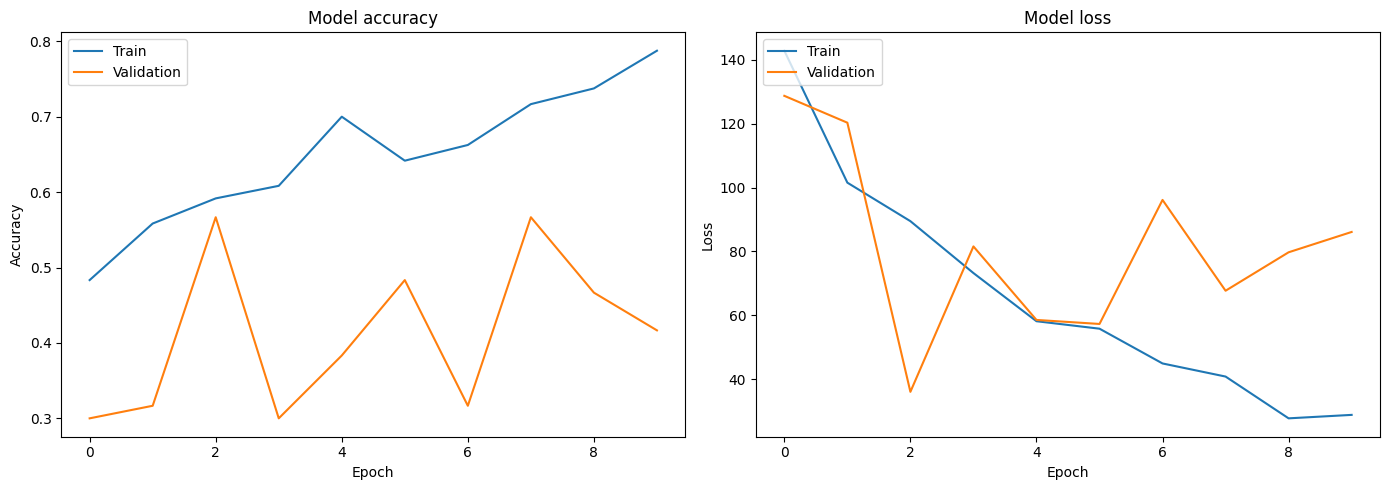

In [29]:
# Plotting training history (optional)
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(history_pairwise.history['accuracy'])
plt.plot(history_pairwise.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_pairwise.history['loss'])
plt.plot(history_pairwise.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [35]:
# 1. Generate Synthetic Test Strings
test_sentences_system_prompt = ["You are a helpful assistant designed to provide information on a variety of topics."]
test_sentences_question = ["What's the difference between classical and quantum computing?"]
test_sentences_response = ["Classical computing uses bits (0s or 1s), while quantum computing uses qubits, which can be both 0 and 1 simultaneously due to superposition. This gives quantum computers potential for greater computational power."]
test_sentences_instruct_model_response = ["Classical computers use bits, either 0 or 1. Quantum computers use qubits that can represent both 0 and 1 at the same time, allowing them to process more information."]
test_sentences_openorca_model_response = ["Regular computers use bits. Quantum ones use qubits that can be 0 and 1 at once. It's like they're super-charged!"]

# 2. Convert Strings to Embeddings
embeddings_system_prompt = get_embeddings(test_sentences_system_prompt, 64)
embeddings_question = get_embeddings(test_sentences_question, 512)
embeddings_response = get_embeddings(test_sentences_response, 512)
embeddings_instruct_model_response = get_embeddings(test_sentences_instruct_model_response, 512)
embeddings_openorca_model_response = get_embeddings(test_sentences_openorca_model_response, 512)

# 3. Concatenate Embeddings
X_test_A_B = tf.concat([
    embeddings_system_prompt,
    embeddings_question,
    embeddings_response,
    embeddings_instruct_model_response], axis=1)

X_test_A_C = tf.concat([
    embeddings_system_prompt,
    embeddings_question,
    embeddings_response,
    embeddings_openorca_model_response], axis=1)

X_test_B_C = tf.concat([
    embeddings_system_prompt,
    embeddings_question,
    embeddings_instruct_model_response,
    embeddings_openorca_model_response], axis=1)

# 4. Predict Rankings
predictions_A_B = model_pairwise.predict(X_test_A_B)
predicted_indices_A_B = np.argmax(predictions_A_B, axis=1)

predictions_A_C = model_pairwise.predict(X_test_A_C)
predicted_indices_A_C = np.argmax(predictions_A_C, axis=1)

predictions_B_C = model_pairwise.predict(X_test_B_C)
predicted_indices_B_C = np.argmax(predictions_B_C, axis=1)

predicted_indices_all = np.concatenate([predicted_indices_A_B, predicted_indices_A_C, predicted_indices_B_C], axis=0)

# 5. Decode Predictions to human-readable rankings
ranking_dict_pairwise = {
    0: "Response 1, Response 2",
    1: "Response 2, Response 1",
}

decoded_rankings_pairwise = [ranking_dict_pairwise[idx] for idx in predicted_indices_all]

# Display some of the decoded rankings
print(decoded_rankings_pairwise)

1/1 [==============================] - 0s 22ms/step
['Response 1, Response 2', 'Response 1, Response 2', 'Response 1, Response 2']
